In [3]:
import os
# import drjit
gpu_num = 1 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
import pickle
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

### Putting Time Domain Graphs together
#### Multitap-Rayleigh

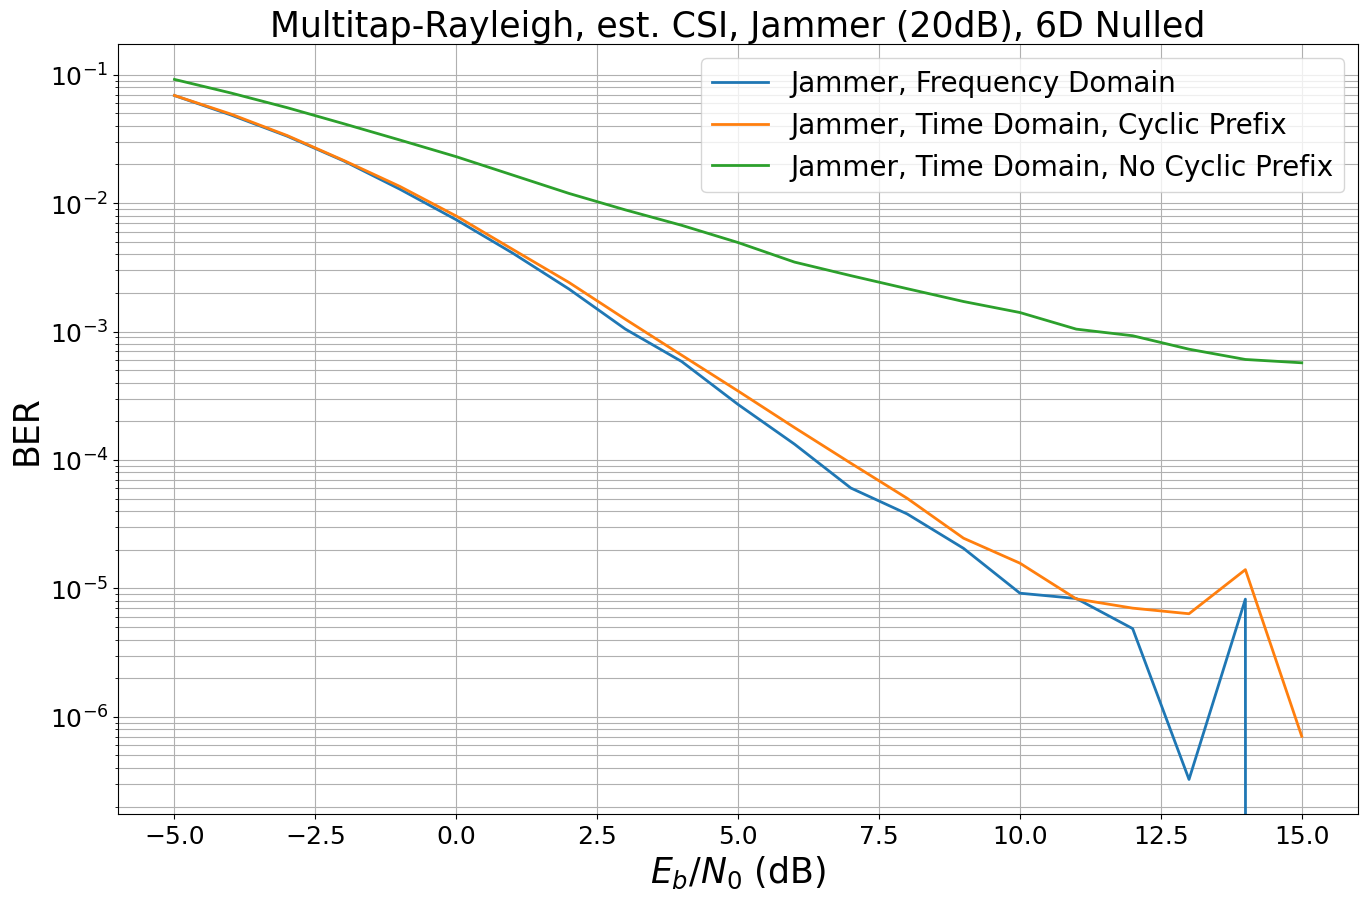

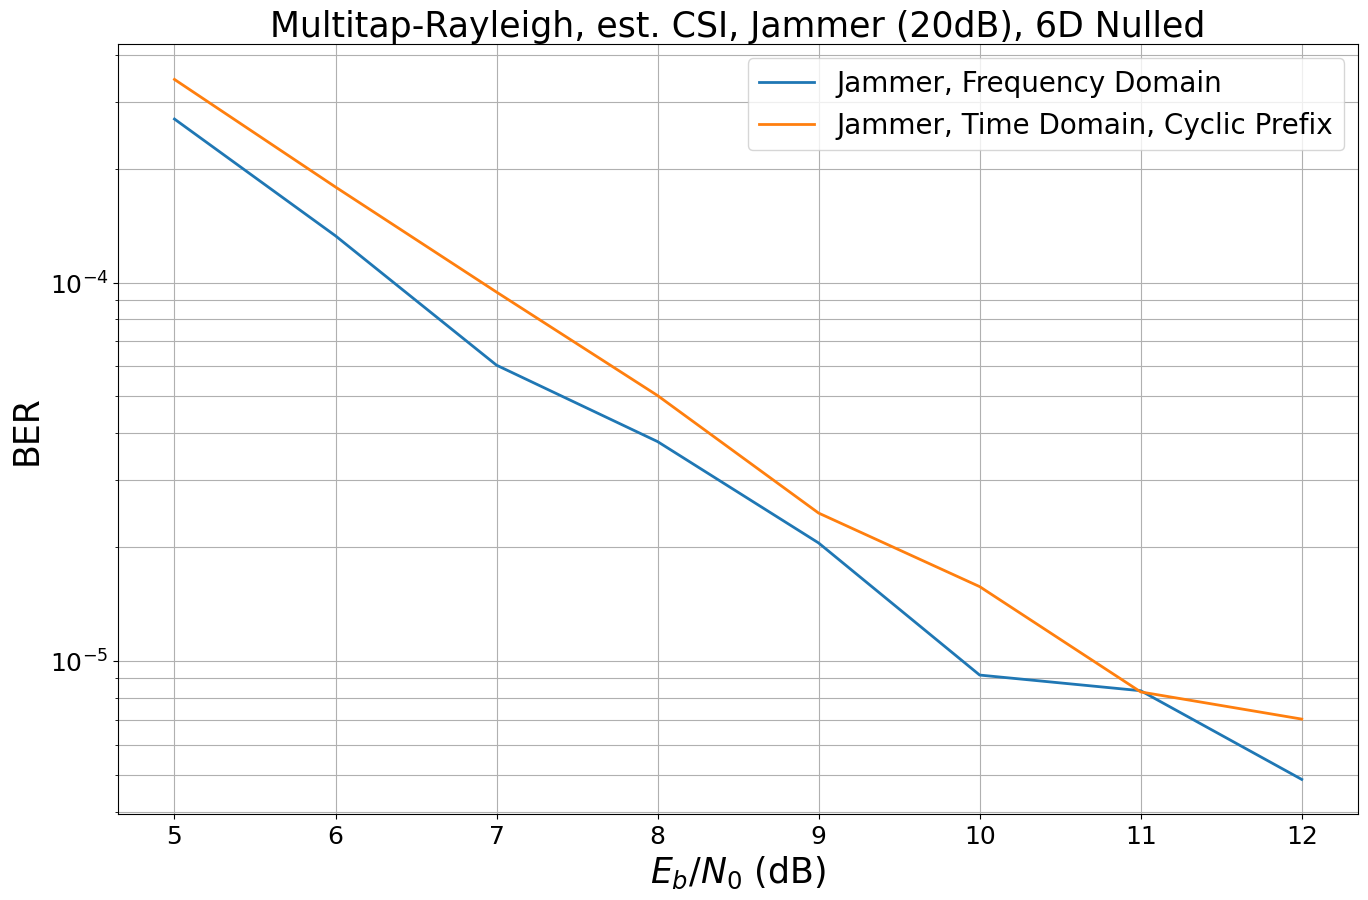

In [45]:
with open("bers/time_pos_rayleigh.pickle", 'rb') as f:
    first = pickle.load(f)
with open("bers2/time_pos_rayleigh.pickle", 'rb') as f:
    second = pickle.load(f)
    
first()
second()

In [23]:
# check legends
print(first._legends[0])
print(second._legends[0])
# check snrs
print(first._snrs[0][10:18])
print(second._snrs[0])

print(first._bers[0][10:18])
print(second._bers[0])

np_to_replace = first._bers[0].numpy()
np_to_replace[10:18] = second._bers[0].numpy()
first._bers[0] = tf.convert_to_tensor(np_to_replace)


# check legends
print(first._legends[1])
print(second._legends[1])
# check snrs
print(first._snrs[1][10:18])
print(second._snrs[1])

print(first._bers[1][10:18])
print(second._bers[1])

np_to_replace = first._bers[1].numpy()
np_to_replace[10:18] = second._bers[1].numpy()
first._bers[1] = tf.convert_to_tensor(np_to_replace)

Jammer, Frequency Domain
Jammer, Frequency Domain
[ 5.  6.  7.  8.  9. 10. 11. 12.]
[ 5.  6.  7.  8.  9. 10. 11. 12.]
tf.Tensor(
[2.70406087e-04 1.32843018e-04 6.04654948e-05 3.79842122e-05
 2.04976400e-05 9.17561849e-06 8.34147135e-06 4.86246745e-06], shape=(8,), dtype=float64)
tf.Tensor(
[2.70406087e-04 1.32843018e-04 6.04654948e-05 3.79842122e-05
 2.04976400e-05 9.17561849e-06 8.34147135e-06 4.86246745e-06], shape=(8,), dtype=float64)
Jammer, Time Domain, Cyclic Prefix
Jammer, Time Domain, Cyclic Prefix
[ 5.  6.  7.  8.  9. 10. 11. 12.]
[ 5.  6.  7.  8.  9. 10. 11. 12.]
tf.Tensor(
[3.28342014e-04 1.57606337e-04 7.99153646e-05 5.53927951e-05
 2.71809896e-05 1.77408854e-05 7.32421875e-06 3.47222222e-06], shape=(8,), dtype=float64)
tf.Tensor(
[3.44106038e-04 1.78792318e-04 9.43400065e-05 5.02624512e-05
 2.45869954e-05 1.57165527e-05 8.28043620e-06 7.01904297e-06], shape=(8,), dtype=float64)


In [48]:
np_to_replace = first._bers[0].numpy()
np_to_replace[18:] = 0.
first._bers[0] = tf.convert_to_tensor(np_to_replace)

np_to_replace = first._bers[1].numpy()
np_to_replace[18:] = 0.
first._bers[1] = tf.convert_to_tensor(np_to_replace)

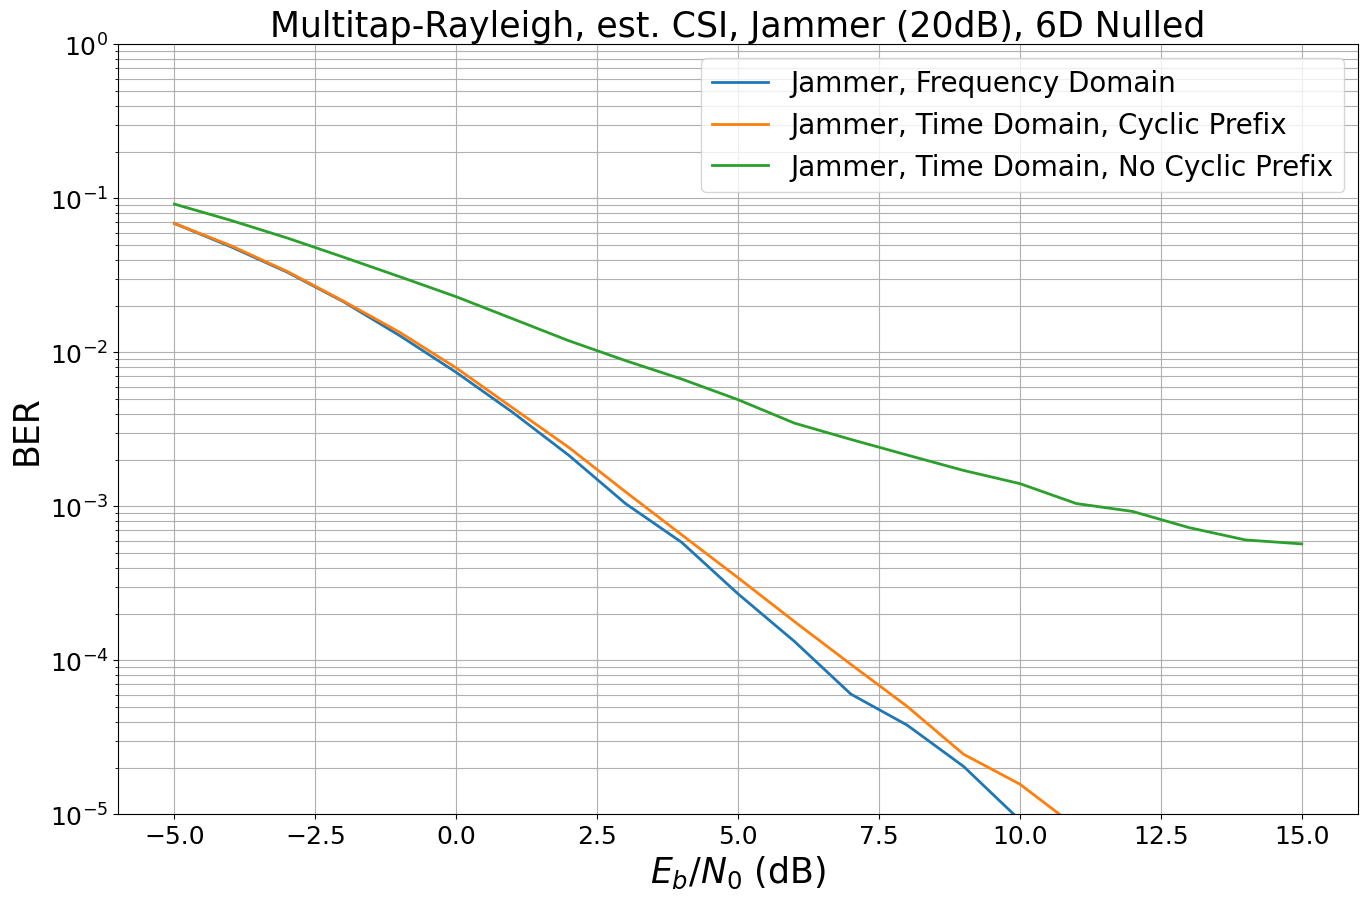

In [49]:
first(ylim=(1e-5, 1))

In [50]:
with open("bers/time_pos_rayleigh.pickle", 'wb') as f:
    first = pickle.dump(first, f)

#### UMi

## RG Display

This seems to be a bug in pilot_pattern.show(). Starts to show up when fft_size >= 128, but not when fft_size <=64

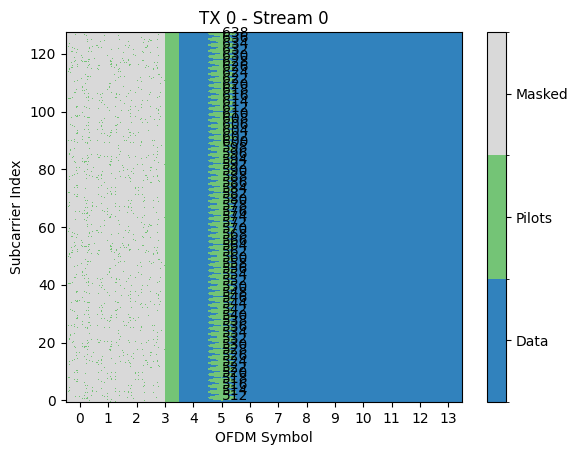

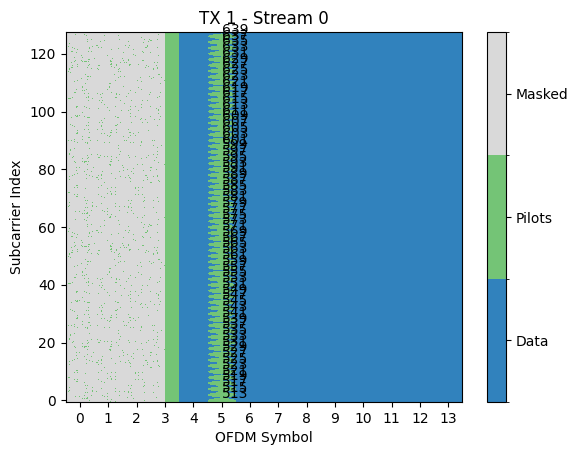

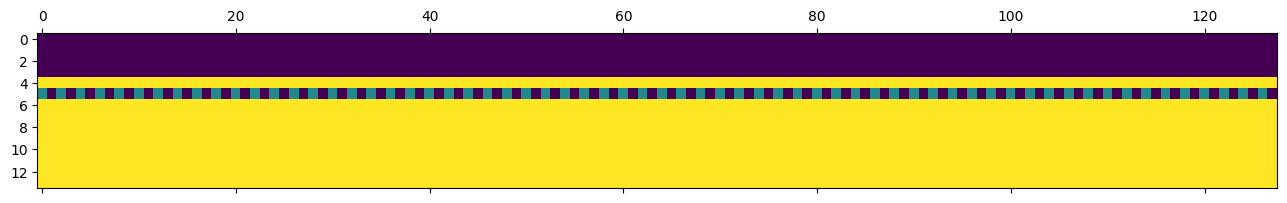

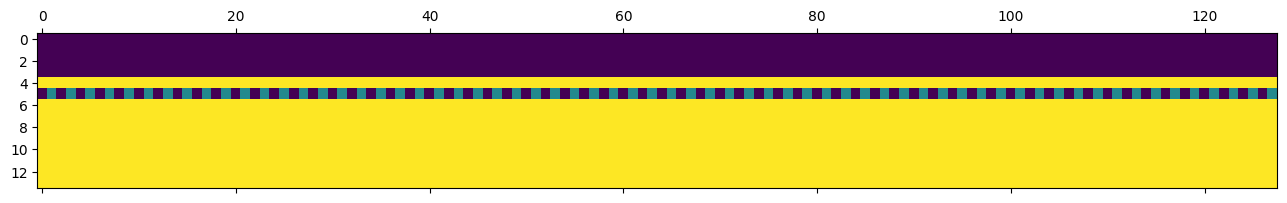

In [104]:
import tensorflow as tf
import numpy as np
from sionna.channel import OFDMChannel, RayleighBlockFading
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, KroneckerPilotPattern, LSChannelEstimator
from sionna.mapping import Mapper, Demapper
from sionna.utils import ebnodb2no, BinarySource, compute_ber
from jammer.pilots import PilotPatternWithSilence
from jammer.jammer import OFDMJammer
from jammer.mitigation.IAN import IanLMMSEEqualizer
from jammer.utils import covariance_estimation_from_signals

# Jammer simulation over Rayleigh block fading channel with CSI estimation
# Normal OFDM init
num_ofdm_symbols = 14
fft_size = 128
num_ut = 2
num_ut_ant = 1
silent_symbols = np.arange(4)

no = ebnodb2no(10., 2, 1)
rg = ResourceGrid(num_ofdm_symbols, fft_size, 30e3, num_ut, num_ut_ant,
                  pilot_pattern="kronecker", pilot_ofdm_symbol_indices=(5,))


rg.pilot_pattern = PilotPatternWithSilence(rg.pilot_pattern, silent_symbols)
rg.pilot_pattern.show(show_pilot_ind=True)
indices = tf.where(rg.pilot_pattern.mask)
updates = sionna.utils.flatten_last_dims(rg.pilot_pattern.pilots, 3)
shape = rg.pilot_pattern.mask.shape
filled = tf.tensor_scatter_nd_update(tf.ones(shape, tf.complex64) * 3, indices, updates)
for i in range(num_ut): 
    plt.matshow(np.abs(filled.numpy()[i,0]), aspect='auto')

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

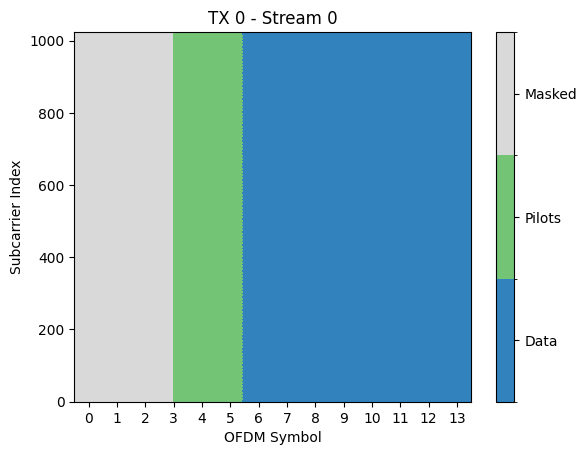

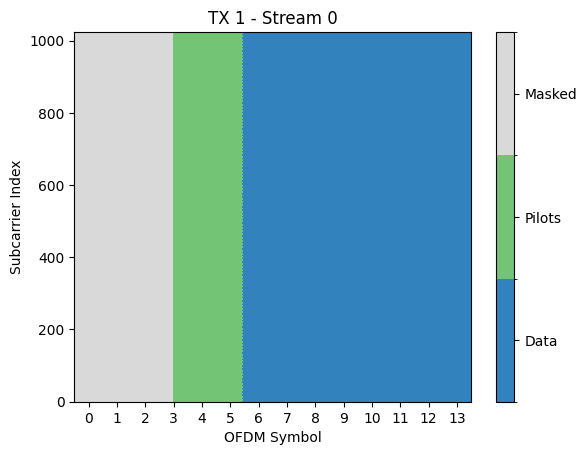

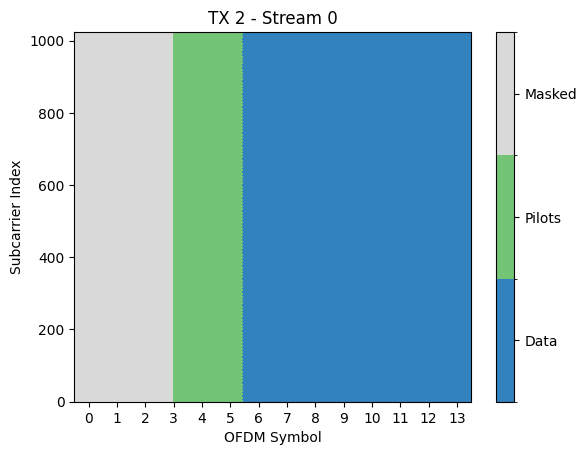

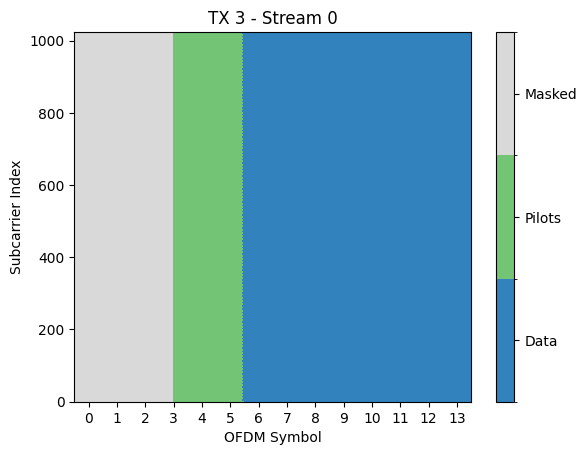

In [98]:
num_ofdm_symbols = 14
fft_size = 1024
num_ut = 4
num_ut_ant = 1
silent_symbols = np.arange(4)

no = ebnodb2no(10., 2, 1)
rg = ResourceGrid(num_ofdm_symbols, fft_size, 30e3, num_ut, num_ut_ant,
                  pilot_pattern="kronecker", pilot_ofdm_symbol_indices=(4, 5))


rg.pilot_pattern = PilotPatternWithSilence(rg.pilot_pattern, silent_symbols)
rg.pilot_pattern.show()

### Block error Rate of Trained vs. Untrained Jammer

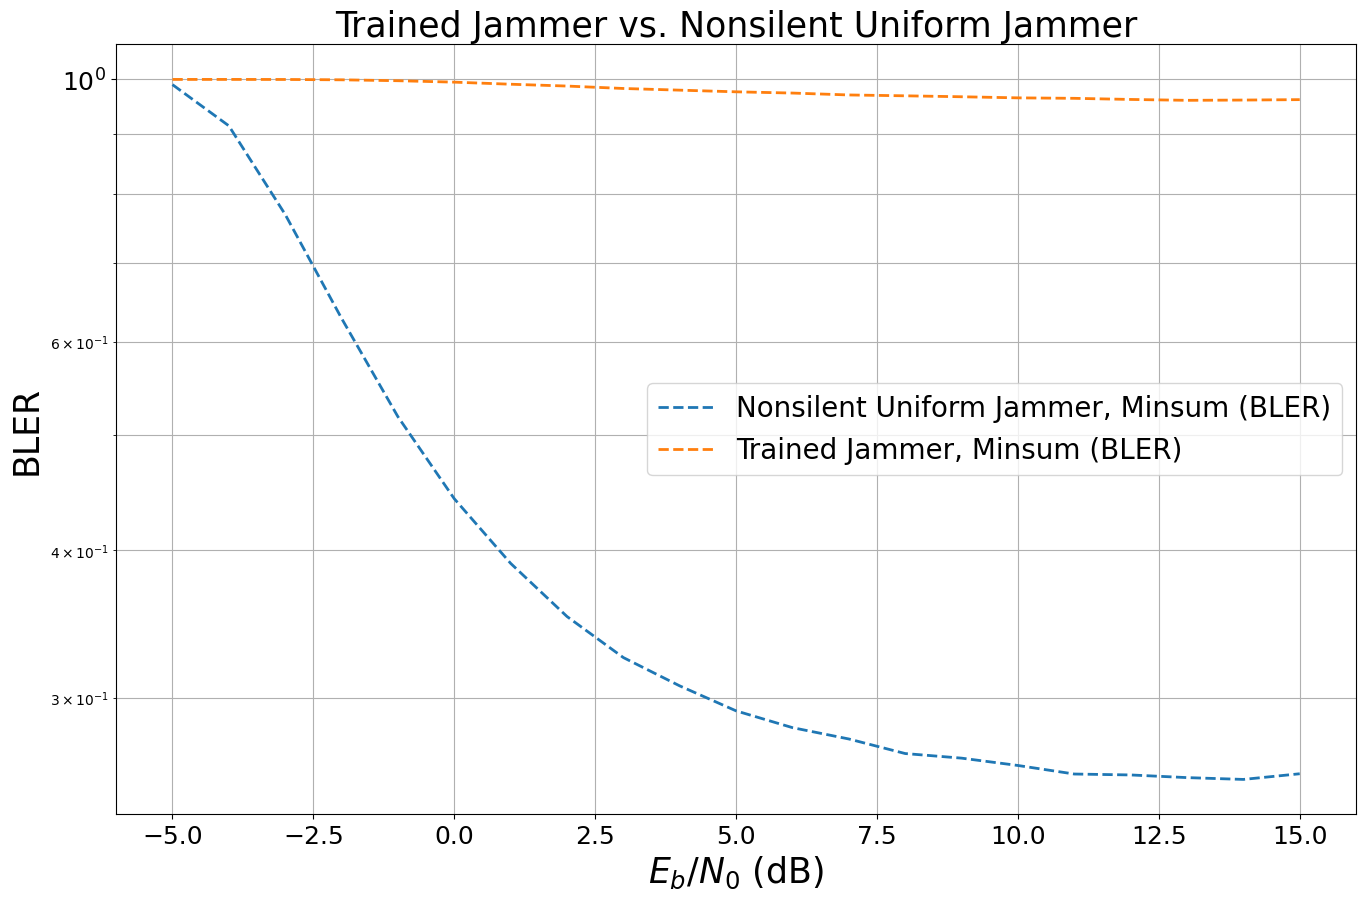

: 

In [6]:
with open("bers/coded_bler.pickle", 'rb') as f:
    bers = pickle.load(f)

bers.remove(0)
bers.remove(0)
bers(show_ber=False)